# 01 — Data Preparation

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image

DATA_DIR = Path("../data")
MANIFEST = DATA_DIR / "manifest.csv"
assert MANIFEST.exists(), f"Missing {MANIFEST}, run build_manifest_mmOTU.py first."

manifest = pd.read_csv(MANIFEST)
print("Manifest rows:", len(manifest))
manifest.head()

Manifest rows: 1469


,image_path,label
0,data/images/658.JPG,0
1,data/images/384.JPG,0
2,data/images/367.JPG,0
3,data/images/730.JPG,0
4,data/images/1426.JPG,1


In [2]:
np.random.seed(42)

def generate_biomarkers(df):
    biomarkers = []
    for _, row in df.iterrows():
        # Binary label (0=benign, 1=malignant)
        label = row["label"]

        age = np.random.randint(28, 79)  # 28–78
        if label == 0:  # benign
            ca125 = np.random.uniform(5, 35)
        else:           # malignant
            ca125 = np.random.uniform(35, 600)

        # ~10–15% BRCA positive overall, but higher in malignant
        if label == 1:
            brca = np.random.choice([0, 1], p=[0.8, 0.2])
        else:
            brca = np.random.choice([0, 1], p=[0.9, 0.1])

        biomarkers.append((age, ca125, brca))

    bio_df = pd.DataFrame(biomarkers, columns=["age", "ca125", "brca"])
    return pd.concat([df.reset_index(drop=True), bio_df], axis=1)

manifest_bio = generate_biomarkers(manifest)
manifest_bio.to_csv(DATA_DIR / "manifest_with_biomarkers.csv", index=False)
manifest_bio.head()

,image_path,label,age,ca125,brca
0,data/images/658.JPG,0,66,28.896290,0
1,data/images/384.JPG,0,35,22.959755,0
2,data/images/367.JPG,0,46,7.999247,0
3,data/images/730.JPG,0,63,9.286005,0
4,data/images/1426.JPG,1,29,442.929306,1


In [3]:
scaler = StandardScaler()
manifest_bio[["age", "ca125"]] = scaler.fit_transform(manifest_bio[["age", "ca125"]])

print(manifest_bio.describe())

             label           age         ca125         brca
count  1469.000000  1.469000e+03  1.469000e+03  1469.000000
mean      0.036079  1.838027e-16 -6.046143e-18     0.100749
std       0.186550  1.000341e+00  1.000341e+00     0.301098
min       0.000000 -1.738640e+00 -4.098453e-01     0.000000
25%       0.000000 -8.518363e-01 -2.848689e-01     0.000000
50%       0.000000  3.496690e-02 -1.536853e-01     0.000000
75%       0.000000  8.535545e-01 -4.296456e-02     0.000000
max       1.000000  1.672142e+00  8.664125e+00     1.000000


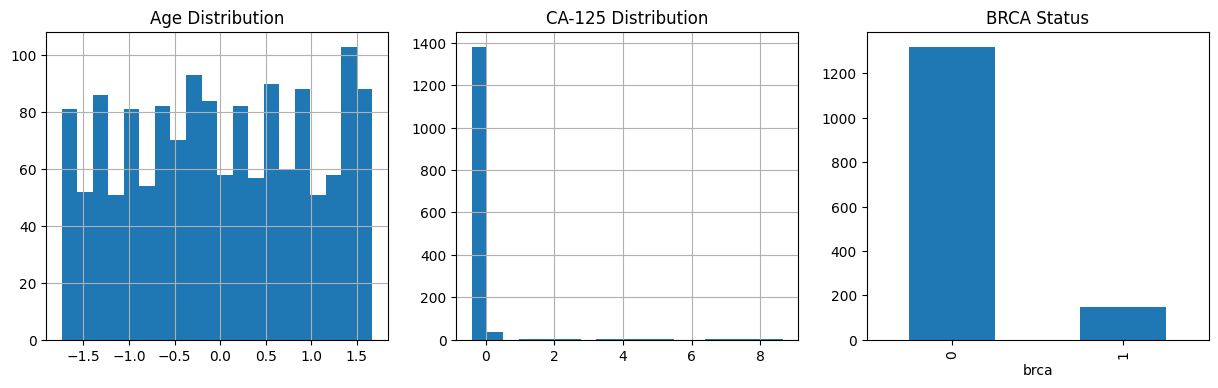

Benign vs Malignant counts:
label
0    1416
1      53
Name: count, dtype: int64


In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

manifest_bio["age"].hist(ax=axs[0], bins=20)
axs[0].set_title("Age Distribution")

manifest_bio["ca125"].hist(ax=axs[1], bins=20)
axs[1].set_title("CA-125 Distribution")

manifest_bio["brca"].value_counts().plot(kind="bar", ax=axs[2])
axs[2].set_title("BRCA Status")

plt.show()

print("Benign vs Malignant counts:")
print(manifest_bio["label"].value_counts())

In [5]:
manifest_bio["filename"] = manifest_bio["image_path"].apply(lambda p: Path(p).name)

def load_ids(split):
    p = Path("../splits") / f"{split}_cls.txt"
    with open(p) as f:
        return set([line.strip().split()[0] for line in f if line.strip()])

splits = {}
for split in ["train", "val", "test"]:
    ids = load_ids(split)
    df_split = manifest_bio[manifest_bio["filename"].isin(ids)].copy()
    splits[split] = df_split

# sanity checks (must pass)
n_total = sum(len(df) for df in splits.values())
assert n_total == len(manifest_bio), (n_total, len(manifest_bio))
assert set(splits["train"]["filename"]).isdisjoint(set(splits["val"]["filename"]))
assert set(splits["train"]["filename"]).isdisjoint(set(splits["test"]["filename"]))
assert set(splits["val"]["filename"]).isdisjoint(set(splits["test"]["filename"]))
print({k: len(v) for k,v in splits.items()})

# save
artifacts = Path("../artifacts"); artifacts.mkdir(parents=True, exist_ok=True)
for split, df in splits.items():
    df.to_parquet(artifacts / f"{split}.parquet", index=False)
    print(f"Saved {split}: {len(df)} -> {artifacts/f'{split}.parquet'}")


{'train': 1000, 'val': 235, 'test': 234}
Saved train: 1000 -> ..\artifacts\train.parquet
Saved val: 235 -> ..\artifacts\val.parquet
Saved test: 234 -> ..\artifacts\test.parquet


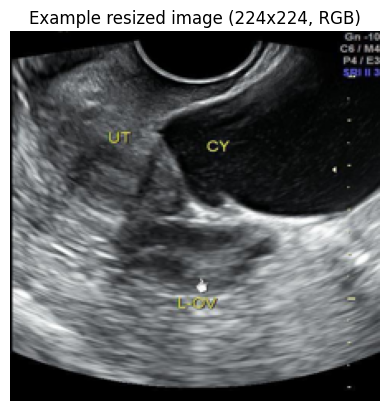

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = Path("..") / manifest_bio.iloc[0]["image_path"]
sample_img = Image.open(img_path).convert("RGB")
sample_img = sample_img.resize((224, 224))

plt.imshow(sample_img)
plt.title("Example resized image (224x224, RGB)")
plt.axis("off")
plt.show()
